# Working with MySQL slow log data like Data Scientist. #

The possibilities of pandas for filtering and aggregating data are wide and convenient. Advanced graphics tools allow you to visualize data in a non-standard way.

Obfuscated data taken from some real mysql server will be used.


## Problem ##

An accident has occurred due to a failed setup of mysql tmpdir. The ramdisk size has not been set large enough. It is necessary to estimate the safe size of tmpdir based only on the mysql slow log data

Perhaps this example is contrived, but when investigating events that have already taken place, there is no way to reconfigure the server to store logs in a table. We have to deal with the information we have.

In [1]:
import pandas as pd
import mysqlslowlog # this module

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

a set of files has been downloaded and placed in the **slowlog** directory

In [3]:
import glob
files = sorted(glob.glob('slowlog/mariadb*'))

We read and combine all the data into one dataframe

In [4]:
alldata = pd.DataFrame()
for filename in files:
    print(filename)
    onefile  = mysqlslowlog.read(filename,save_sql=False)
    alldata = pd.concat([alldata,onefile])
    
#alldata=alldata.sort_index()

alldata = alldata.drop(columns='schema') # need obfuscate some columns for privacy

slowlog/mariadb-slow.log
slowlog/mariadb-slow.log.1.gz
slowlog/mariadb-slow.log.2.gz
slowlog/mariadb-slow.log.3.gz
slowlog/mariadb-slow.log.4.gz
slowlog/mariadb-slow.log.5.gz
slowlog/mariadb-slow.log.6.gz
slowlog/mariadb-slow.log.7.gz


In [5]:
# are the data types as expected ?
alldata.dtypes

timestamp            datetime64[ns]
sqltext                      object
rows_sent                     int64
rows_examined                 int64
rows_affected                 int64
bytes_sent                    int64
tmp_table_sizes               int64
tmp_tables                    int64
tmp_disk_tables               int64
merge_passes                  int64
query_time                  float64
lock_time                   float64
full_scan                      bool
full_join                      bool
tmp_table                      bool
tmp_table_on_disk              bool
filesort                       bool
filesort_on_disk               bool
dtype: object

In [6]:
# total records
alldata.shape

(4642, 18)

In [7]:
# summary of the memory occupied by the data:
alldata.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4642 entries, 0 to 521
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   timestamp          4642 non-null   datetime64[ns]
 1   sqltext            4642 non-null   object        
 2   rows_sent          4642 non-null   int64         
 3   rows_examined      4642 non-null   int64         
 4   rows_affected      4642 non-null   int64         
 5   bytes_sent         4642 non-null   int64         
 6   tmp_table_sizes    4642 non-null   int64         
 7   tmp_tables         4642 non-null   int64         
 8   tmp_disk_tables    4642 non-null   int64         
 9   merge_passes       4642 non-null   int64         
 10  query_time         4642 non-null   float64       
 11  lock_time          4642 non-null   float64       
 12  full_scan          4642 non-null   bool          
 13  full_join          4642 non-null   bool          
 14  tmp_table

In [8]:
# Convert bytes to megabytes.
# In this form, the data is more familiar to evaluate.
alldata['tmp_table_sizes_mb'] = alldata['tmp_table_sizes']/(1024*1024)

## Accident ##
We are interested in the behavior of the server in the vicinity of 2022-07-14.
Let's delete the extra data on the time interval.

We are also interested in queries that involve sorting on disk

The logical expression that combines all these conditions looks like this:

In [9]:
df = alldata[(pd.Timestamp('2022-07-14 00:00') <alldata.timestamp )
             & (alldata.timestamp < pd.Timestamp('2022-07-14 19:00'))
             & alldata.tmp_table_on_disk]

evaluate whether the data is loaded and preprocessed correctly

In [10]:
df.head(5)

,timestamp,sqltext,rows_sent,rows_examined,rows_affected,bytes_sent,tmp_table_sizes,tmp_tables,tmp_disk_tables,merge_passes,query_time,lock_time,full_scan,full_join,tmp_table,tmp_table_on_disk,filesort,filesort_on_disk,tmp_table_sizes_mb
0,2022-07-14 00:00:10,,100,1766939,0,344376,543612928,3,2,0,8.830811,0.000167,True,False,True,True,True,False,518.429688
3,2022-07-14 00:05:10,,100,1766919,0,348708,543465472,3,2,0,8.492314,0.000195,True,False,True,True,True,False,518.289062
4,2022-07-14 00:10:10,,100,1766922,0,348607,543457280,3,2,0,8.634478,0.000161,True,False,True,True,True,False,518.281250
5,2022-07-14 00:15:10,,100,1766922,0,348607,543457280,3,2,0,8.627150,0.000126,True,False,True,True,True,False,518.281250
6,2022-07-14 00:20:09,,100,1766922,0,348607,543457280,3,2,0,8.635135,0.000192,True,False,True,True,True,False,518.281250


Let's try a naive way to display the data

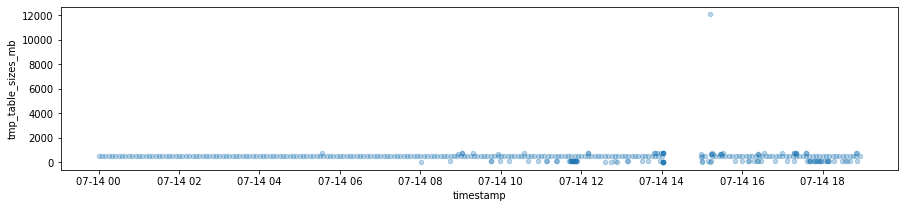

In [11]:
df.plot(kind='scatter',x='timestamp',y='tmp_table_sizes_mb',figsize=(15,3),alpha=0.3,s=20);

Obviously, these events are difficult to perceive as a process. 
Therefore, we regroup the data and for this we need pandas!

In [12]:
sortbytes=df.resample('5min',on='timestamp')['tmp_table_sizes_mb'].sum()
sortbytes.head(5)

timestamp
2022-07-14 00:00:00    518.429688
2022-07-14 00:05:00    518.289062
2022-07-14 00:10:00    518.281250
2022-07-14 00:15:00    518.281250
2022-07-14 00:20:00    518.281250
Freq: 5T, Name: tmp_table_sizes_mb, dtype: float64

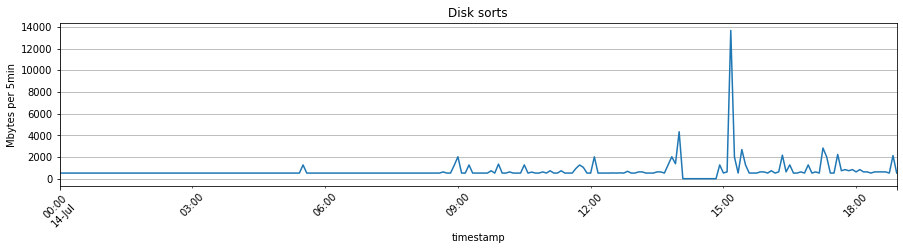

In [13]:
sortbytes.plot(figsize=(15,3),grid=True,rot=45,
               ylabel='Mbytes per 5min',
               title='Disk sorts');

Due to the accident, not all requests completed and ended up in the log.
It can be seen that before the accident, the amount of bytes increased. And after the crash, 12GB was successfully sorted.

Smaller interval will show whether the excess at the time of the accident was critical:

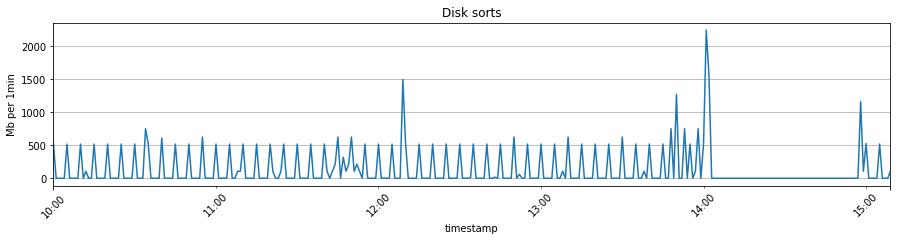

In [14]:
alldata[(pd.Timestamp('2022-07-14 10:00') <alldata.timestamp )  \
         & (alldata.timestamp < pd.Timestamp('2022-07-14 15:10')
         )
         & alldata.tmp_table_on_disk] \
    .resample('1min',on='timestamp')['tmp_table_sizes_mb'].sum() \
    .plot(figsize=(15,3),grid=True,rot=45,ylabel='Mb per 1min',title='Disk sorts');

## Code changes   ## 
A after changes in the code, the amount of sorted data has decreased significantly.
We can draw this.

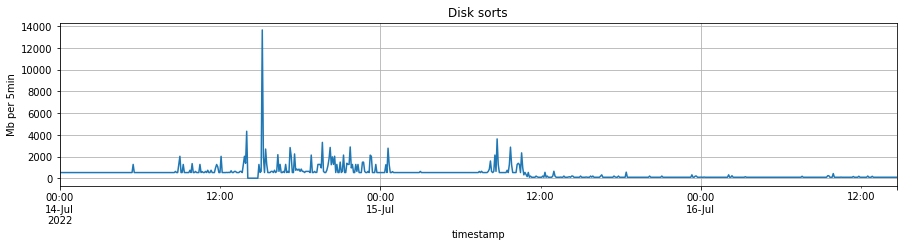

In [15]:
alldata[(pd.Timestamp('2022-07-14 00:00') <alldata.timestamp )  \
         & (alldata.timestamp < pd.Timestamp('2022-07-18 0:00')
         )
         & alldata.tmp_table_on_disk] \
    .resample('5min',on='timestamp')['tmp_table_sizes_mb'] \
    .sum() \
    .plot(figsize=(15,3),grid=True,rot=0,
          ylabel='Mb per 5min',
          title='Disk sorts');